Goal: assume A is periodic, improve the ADMM code to make it faster.

Now in the main function myADMM, the complexity for each iteration is O(N).

In [ ]:
pip install ipdb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import cvxpy as cp
import scipy as sp
import scipy.sparse.linalg
from scipy.ndimage import correlate
from scipy.linalg import circulant
from numpy.linalg import matrix_power
from scipy.ndimage import gaussian_filter1d
import ipdb
import warnings
import time
warnings.filterwarnings("ignore")

The idea for the dominant step:

$(2\epsilon A^TA+\rho I)x=2\epsilon A^Ty+\rho(z-u),\ A^TA=F\Sigma^2F^H$, i.e.,

$F(2\epsilon\Sigma^2+\rho I)F^Hx=2\epsilon F\Sigma F^Hy+\rho(z-u)$,

$(2\epsilon\Sigma^2+\rho I)F^Hx=2\epsilon \Sigma F^Hy+\rho F^H(z-u)$,

$x=F(2\epsilon\Sigma^2+\rho I)^{-1}(2\epsilon\Sigma F^Hy+\rho F^H(z-u))$

In [25]:
#ADMM for solving min_x ||x||_1 + \epsilon*||y-Ax||^2   st. x>=0  (may not have this constrain)
#here A=F\SigmaF^H
#this function can be used to solve (7) for 1D/2D sparse signal
def myADMM(Sigma,y,constrain=False,maxit=3000,tol=1e-6,epsilon=1e2,rho=50):
  #the choice of rho must be careful!
  N = len(y)
  y = y.reshape(N,)
  err = []
  loss = []
  x = y#np.random.randn(N,)
  z = np.random.randn(N,)
  u = np.random.randn(N,)
  Fy = sp.fft.fft(y).conjugate()
  d = np.real((2*epsilon*Sigma**2+rho*sp.sparse.eye(N)).diagonal())
  invD = sp.sparse.diags(1/d,0)
  if constrain == True:
    for i in range(maxit):
      #x = np.real(F@(invD@(2*epsilon*Sigma@(F.conjugate()@y)+rho*F.conjugate()@(z-u))))
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*sp.fft.fft(z-u).conjugate())))/N
      loss.append(np.linalg.norm(x, 0.5)**0.5+np.linalg.norm(x, 2)**2*1e-4)
      z = ((x+u)>(1./rho))*(x+u-1./rho)
      u = u + x - z
      err.append(np.linalg.norm(x-z))
      if i>50 and np.linalg.norm(x-z) < tol:
        print('iter',i)
        break
  else: 
    for i in range(maxit):
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*sp.fft.fft(z-u).conjugate())))/N
      loss.append(np.linalg.norm(x, 0.5)**0.5+np.linalg.norm(x, 2)**2*1e-4)
      z = (abs(x+u)>(1./rho))*(abs(x+u)-1./rho)*np.sign(x+u)
      u = u + x - z
      err.append(np.linalg.norm(x-z))
      if i>100 and np.linalg.norm(x-z) < tol:
        print('iter',i)
        break
  return z,err,loss
def l1solv(Fw1,meas,constraint=True,epsilon=1e2,power=2):
# Create variable.
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(x_l1, 1)+ epsilon*cp.norm((Fw1@x_l1)-meas, 2)**power)
# Form and solve problem.
   if constraint == True:
     prob = cp.Problem(obj, constraints)
   else:
     prob = cp.Problem(obj)
   prob.solve()
   #mx_norm = torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 0.5)**0.5+(torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 2))**2*1e-4
   #psnr_recon = psnr2(u,x_l1.value.T)
   #print('psnr:{:f}, mixednorm:{:f}'.format(psnr_recon,mx_norm))
   return x_l1.value
def psnr1(A,B):
  MSE = torch.mean((A-B)**2)**0.5
  return 20*np.log(torch.max(torch.abs(A))/MSE)/np.log(10)
def psnr2(A,B):
  MSE = np.mean((A-B)**2)**0.5
  return 20*np.log(np.amax(abs(A))/MSE)/np.log(10)

In [4]:
#check correctness of the function above, compare with cvx 
def mytest(constraint=False,maxit1=3000,A=[],y=[],epsilon1=1e2,rho1=50):
  if A == []:
    N = 100
    A = circulant(np.random.randn(N,1))
    A = A + A.T
    y = np.random.randn(N,1)
    Sigma1 = sp.sparse.diags(np.real(scipy.fft.fft(A[0,:])),0)
  N = len(y)
  x_l1 = cp.Variable(shape=(N,1))
  constraints = [x_l1>=0]
  obj = cp.Minimize(cp.norm(x_l1, 1) + epsilon1*cp.norm(y-A@x_l1, 2)**2) 
  if constraint == False:
    prob = cp.Problem(obj)
    x,err,loss = myADMM(Sigma=Sigma1,y=y,constrain=False,epsilon=epsilon1,rho=rho1,maxit=maxit1)
  else:
    prob = cp.Problem(obj, constraints)
    x,err,loss = myADMM(Sigma=Sigma1,y=y,constrain=True,epsilon=epsilon1,rho=rho1,maxit=maxit1)
  prob.solve()
  x_cvx = x_l1.value
  plt.figure(figsize=(10,5))
  plt.subplot(121),plt.plot(err)
  plt.subplot(122),plt.plot(x,'r'),plt.plot(x_cvx,'b')
  psnr_rec = psnr2(x,x_cvx)
  return x,x_cvx,psnr_rec

iter 101


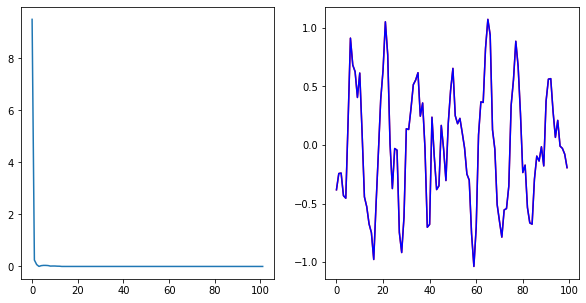

In [5]:
x,x_cvx,psnr_rec=mytest(constraint=False,maxit1=5000,rho1=50)

In [6]:
#1D sparse signal and its mearsurements
def get1D(N=500,Ncount=1000,alpha=5,spikes=10,filter='Gaussian'):
  s = 1 / (2 * alpha)
  A = (1-2*s)*sp.sparse.diags(np.ones((N,)),0) +s*sp.sparse.diags(np.ones((N-1,)),-1)+s*sp.sparse.diags(np.ones((N-1,)),1)
  A[0,-1] = s
  A[-1,0] = s
  D = sp.sparse.diags(np.ones((N,)),0)-sp.sparse.diags(np.ones((N-1,)),-1)

  u = np.zeros((N,1))
  k = np.random.randint(0,N-50,spikes)
  u[k+25] = 50*np.random.rand(spikes,1)
  #u = np.cumsum(u)
  u = abs(u).reshape(N,1)
  u[:60] = 0                      
  u[-60:] = 0
  Sigma = sp.sparse.diags(np.real(scipy.fft.fft(A[0,:].toarray().reshape(N,))))
  if filter == 'Gaussian':
    #meas = gaussian_filter1d(u,100)
    #
    #meas = np.real(sp.fft.fft((Sigma**Ncount@sp.fft.fft(u).conjugate()).reshape(N,))/N)
    Fw = np.linalg.matrix_power(A.toarray(), Ncount)
    meas = (Fw@u).reshape(N,1)
  elif filter == 'average':
    meas = np.copy(u)    
    c = np.stack([np.linspace(0,30,30),np.linspace(30,0,30)],axis=1).T.reshape(60,1)
    for i in range(N-60):
      meas[i+30] = u[i:(i+60)].T.dot(c)/sum(c)
  elif filter == 'triangular':
    n1 = 10
    f = np.concatenate((np.linspace(0,1,n1),np.linspace(0,1,n1)[::-1]),axis=0)
    meas = correlate(u,f)
  return u,meas,Sigma,A
#Fw = np.linalg.matrix_power(A, Ncount)
#meas = (Fw@u).reshape(N,1)
#noise = 1*np.random.randn(meas.shape[0],1)
#measn = meas + noise  

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0ae23e1610>,
 [<matplotlib.lines.Line2D at 0x7f0ae23b5250>])

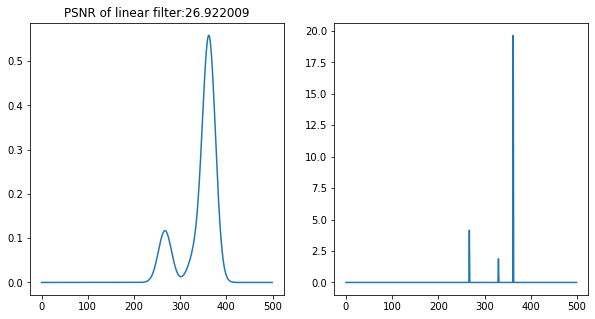

In [8]:
#plot signal and measurenments
N = 500
u,meas,Sigma,A = get1D(N=N,spikes=5,filter='Gaussian')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.plot(meas),plt.title('PSNR of linear filter:{:f}'.format(psnr2(u,meas)))
plt.subplot(122),plt.plot(u)

In [ ]:
t = np.linspace(100,2400,20)
a =[]
b =[]
#Sigma = sp.sparse.diags(np.real(scipy.fft.fft(A[0,:].toarray().reshape(N,))),0)
for ti in range(20):
    u_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas,constrain=True,rho=1,maxit=5000,epsilon=1e3)
    mix_norm = np.linalg.norm((u_rec).reshape(N,), 0.5)**0.5 + 1e-4*(np.linalg.norm((u_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(u,u_rec)
    a.append(mix_norm)
    b.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 100.0 psnr 25.95969849539933 mixed norm: 77.7861352335496
N: 221.05263157894737 psnr 25.938560832833918 mixed norm: 73.00344087019376
N: 342.10526315789474 psnr 25.93734359980527 mixed norm: 68.91538838870036
N: 463.1578947368421 psnr 25.932819822802195 mixed norm: 64.5307976675485
N: 584.2105263157895 psnr 25.908141743839195 mixed norm: 59.915988571620616
N: 705.2631578947369 psnr 25.869687773710847 mixed norm: 57.054719145392575
N: 826.3157894736842 psnr 25.844402363429577 mixed norm: 51.748747451538314
N: 947.3684210526316 psnr 25.756962145337415 mixed norm: 44.38642764693374
N: 1068.421052631579 psnr 24.74269001752953 mixed norm: 23.025554728177617
N: 1189.4736842105262 psnr 23.2499715742678 mixed norm: 13.558299936852023
N: 1310.5263157894738 psnr 23.156497614492455 mixed norm: 13.935350156747033
N: 1431.578947368421 psnr 23.075961636590243 mixed norm: 14.40860151827281
N: 1552.6315789473683 psnr 23.003927481606752 mixed norm: 14.373376524396111
N: 1673.6842105263158 psnr 22.94

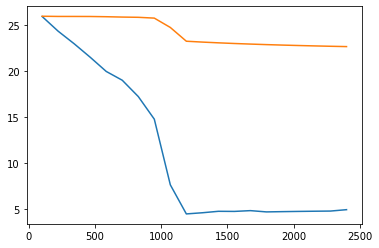

In [ ]:
plt.plot(t,np.array(a)/3)
plt.plot(t,b)

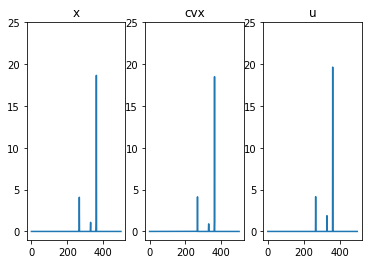

47.78295331231284
46.24009946977922


In [40]:
N_recon =1011#np.round(t[a==np.min(a)])
x,err,loss = myADMM(Sigma**(int(N_recon)),meas,constrain=False,rho=0.1,epsilon=1e3,maxit=3000)
#x_cvx = l1solv(np.linalg.matrix_power(A.toarray(),int(N_recon)),meas,epsilon=1e3,power=2,constraint=True)
plt.subplot(131),plt.plot(x),plt.title('x'),plt.ylim([-1,25])
plt.subplot(132),plt.plot(x_cvx),plt.title('cvx'),plt.ylim([-1,25])
plt.subplot(133),plt.plot(u),plt.title('u'),plt.ylim([-1,25])
plt.show()
print(psnr2(u,x.reshape(N,1)))
print(psnr2(u,x_cvx))

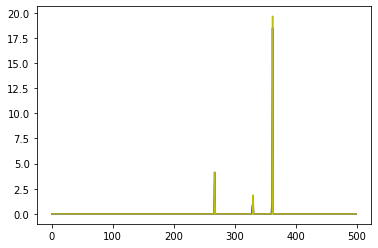

In [33]:
#plt.plot(x,'r')
plt.plot(x_cvx,'b')
plt.plot(u,'y')

In [36]:
u.shape

(500, 1)

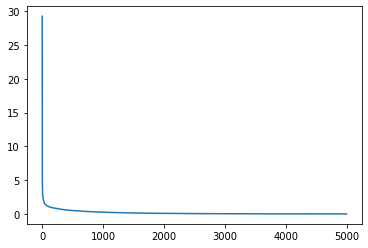

In [ ]:
plt.plot(err)

One example for N=300


In [ ]:
#1D sparse signal and its mearsurements
N = 300
Ncount = 1000
alpha = 5
s = 1 / (2 * alpha)
A = (1-2*s)*np.diag(np.ones((N,1))[:,0],0) +s*np.diag(np.ones((N-1,1))[:,0],-1)+s*np.diag(np.ones((N-1,1))[:,0],1)
A[0,-1] = s
A[-1,0] = s
D = np.diag(np.ones((N,1))[:,0],0)-np.diag(np.ones((N-1,1))[:,0],-1)

spikes = 3
u = np.zeros((N,1))
k = np.random.randint(0,N-50,spikes)
u[k+25] = 50*np.random.rand(spikes,1)
#u = np.cumsum(u)
u = abs(u).reshape(N,1)
u[:60] = 0                      
u[-60:] = 0

In [ ]:
# linear filter
c = np.stack([np.linspace(0,30,30),np.linspace(30,0,30)],axis=1).T.reshape(60,1)
meas1 = np.copy(u)
for i in range(N-60):
    meas1[i+30] = u[i:(i+60)].T.dot(c)/sum(c)
meas1n = meas1 + 5*np.random.randn(meas1.shape[0],1)
# moving window filter
meas2 = np.copy(u)
for i in range(N-60):
    meas2[i+30] = np.mean(u[i:(i+60)])
meas2n = meas2 + 5*np.random.randn(meas2.shape[0],)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb1e7705ed0>,
 [<matplotlib.lines.Line2D at 0x7fb1e774da90>])

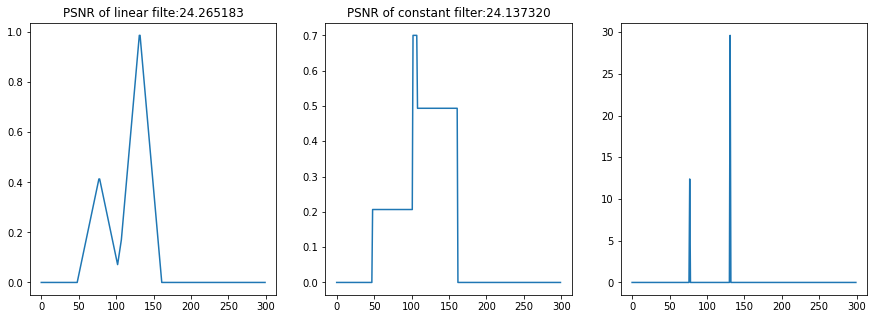

In [ ]:
#plot signal and measurenments
plt.figure(figsize=(15,5))
plt.subplot(131),plt.plot(meas1),plt.title('PSNR of linear filte:{:f}'.format(psnr2(u,meas1)))
plt.subplot(132),plt.plot(meas2),plt.title('PSNR of constant filter:{:f}'.format(psnr2(u,meas2)))
plt.subplot(133),plt.plot(u)

In [ ]:
t = np.linspace(100,2400,20)
a =[]
b =[]
Sigma = sp.sparse.diags(np.real(scipy.fft.fft(A[0,:])),0)
for ti in range(20):
    #u_rec,err,loss = myADMM(sp.sparse.diags(np.real(scipy.fft.fft(A[0,:])),0)**(int(t[ti])),meas1,constrain=True,rho=1,epsilon=1e1)
    u_rec = l1solv(np.linalg.matrix_power(A,int(t[ti])),meas1,constraint=True,epsilon=1e2,power=1)
    mix_norm = np.linalg.norm((u_rec).reshape(N,), 0.5)**0.5 + 1e-4*(np.linalg.norm((u_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(u,u_rec)
    a.append(mix_norm)
    b.append(psnr_rec)
    print('N:',t[ti],'psnr:',psnr_rec,'mixed norm:',mix_norm)

N: 100.0 psnr: 25.13282923638999 mixed norm: 27.48289157606228
N: 221.05263157894737 psnr: 25.863522168467288 mixed norm: 22.594134278917196
N: 342.10526315789474 psnr: 28.499324121175658 mixed norm: 19.727641278638135
N: 463.1578947368421 psnr: 24.624486627417927 mixed norm: 19.522770151524323
N: 584.2105263157895 psnr: 22.784807001904934 mixed norm: 17.11162286647817
N: 705.2631578947369 psnr: 22.529173522516963 mixed norm: 15.062330255734615
N: 826.3157894736842 psnr: 23.557555872714616 mixed norm: 14.755567037296997
N: 947.3684210526316 psnr: 25.911883093370676 mixed norm: 12.715691810111089
N: 1068.421052631579 psnr: 24.322247671637193 mixed norm: 12.615949175528309
N: 1189.4736842105262 psnr: 23.502499071393718 mixed norm: 12.499622564096027
N: 1310.5263157894738 psnr: 23.528837505895225 mixed norm: 12.587828680564225
N: 1431.578947368421 psnr: 23.227596880206775 mixed norm: 12.196576891356797
N: 1552.6315789473683 psnr: 24.098115742391983 mixed norm: 12.607039703061691
N: 1673.6

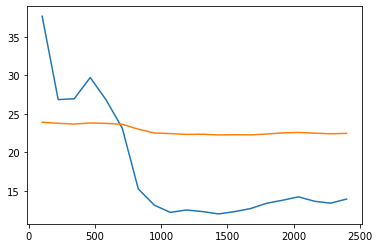

In [ ]:
plt.plot(t,a)
plt.plot(t,b)

iter 2197
21.304158419027157
24.265183056413196


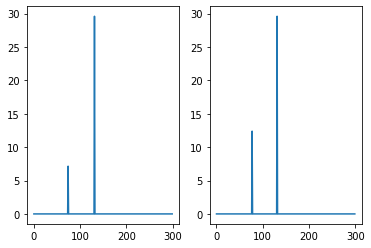

In [ ]:
N_recon =np.round(t[a==np.min(a)])
x,err,loss = myADMM(Sigma**(int(N_recon)),meas1,constrain=True,rho=0.1,epsilon=6e0)
x_cvx = l1solv(np.linalg.matrix_power(A,int(N_recon)),meas1)
plt.subplot(121),plt.plot(x)
plt.subplot(122),plt.plot(u)
print(psnr2(u,x))
print(psnr2(u,meas1))